# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from modul.gravimetri import gravimetri
from modul.bc_model import bc_model
from modul.hs_model import hs_model
from modul.pm_model import pm_model
from modul.extraterrestrial_radiation import extraterrestrial_radiation

# Inisialisasi Variabel

In [2]:
# koordinat
latitude = (-8.188)
altitude = (98)

# Massa jenis air dalam kg/m^3
rho_air = (1000)

# BC Metode berdasarkan tabel persentase hari terang
persentase_hari_terang = (0.27)

kode_groups = ("A", "B", "C", "D", "E", "F")

sisi_media_tanaman = ({
    'A1' : 12.5, 'A2' : 12.5, 'A3' : 12.5, 'A4' : 12.5,
    'B1' : 15.0, 'B2' : 15.0, 'B3' : 15.0, 'B4' : 15.0,
    'C1' : 17.5, 'C2' : 17.5, 'C3' : 17.5, 'C4' : 17.5,
    'D1' : 20.0, 'D2' : 20.0, 'D3' : 20.0, 'D4' : 20.0,
    'E1' : 22.5, 'E2' : 22.5, 'E3' : 22.5, 'E4' : 22.5,
    'F1' : 25.0, 'F2' : 25.0, 'F3' : 25.0, 'F4' : 25.0, })  # Satuan cm



# Import Dataset

In [3]:
# Import file excel
dataset_primer = 'dataset primer/Dataset_ET.xlsx'
dataset_sekunder = 'dataset sekunder/dataset_sekunder.xlsx'

# Membaca semua sheet dari file Excel
data_primer = pd.ExcelFile(dataset_primer)
data_sekunder = pd.ExcelFile(dataset_sekunder)

# Fungsi-Fungsi

In [4]:
# Menghitung luas area di dalam variabel
def hitung_luas_media(sisi):
        cm_to_mm = sisi * 10
        luas = cm_to_mm ** 2
        return luas              # Hasil dalam satuan mm

In [5]:
# Menghitung tanggal pengambilan data
def hitung_tanggal_data(day):
    day = int(day.split()[1])

    tahun = '2024'

    if day > 10:
        bulan = '11'
    else:
        bulan = '10'
    
    def hitung_tanggal(input_day):
        # Jika x antara 1 dan 31, y adalah x + 20, tetapi melingkar kembali ke awal setelah 31
        return (input_day + 21) % 31 if (input_day + 21) % 31 != 0 else 31

    hari = hitung_tanggal(day)
    hari = f"{hari:02d}"

    tanggal = f"{tahun}-{bulan}-{hari}"

    return tanggal

# ET Model Gravimetri/Penimbangan

Perhitungan Gravimetri

In [6]:
hasil_gravimetri = []

for sheet_name in data_primer.sheet_names:
    # Baca data primer dan sekunder dari sheet excel
    df_data_primer = data_primer.parse(sheet_name)
    df_data_sekunder = data_sekunder.parse(sheet_name)
    
    # Logika program Anda
    for kode in sisi_media_tanaman.keys():
        kode_berat = f'berat_{kode}'
        kode_irigasi = f'supply_air_{kode}'
        
        # Buat array untuk variabel yang akan digunakan
        waktu = df_data_primer['waktu'].array
        berat = df_data_primer[kode_berat].array                            # Satuan kg
        irigasi_liter = df_data_primer[kode_irigasi].fillna(0).array        # Satuan liter
        curah_hujan = df_data_sekunder['curah_hujan'].array                 # Satuan mm

        # Hitung luas alas media tanaman
        luas_media = hitung_luas_media(sisi_media_tanaman[kode])    # Satuan mm^2

        # Ubah irigasi ke satuan mm
        irigasi_mm = (irigasi_liter * 1e6) / (luas_media)           # Satuan mm

        # Ubah berat ke satuan volume mm^3
        volume = berat * 1e6                                        # Satuan mm^3

        # Hitung total supply air
        supply_air = irigasi_mm + curah_hujan                       # Satuan mm

        perubahan_berat, perubahan_et, et_total = evapotranspirasi = gravimetri(berat=volume,
                                                                                waktu=waktu,
                                                                                luas=luas_media,
                                                                                supply_air=supply_air
                                                                                )

        # Simpan hasil ke list
        hasil_gravimetri.append({
            "Day": sheet_name,
            "Kode": kode,
            "ET Total": et_total
        })

# Buat DataFrame dari hasil
df_hasil_gravimetri = pd.DataFrame(hasil_gravimetri)

# Pivot tabel dengan "Day" sebagai index dan "Kode" sebagai kolom
df_hasil_gravimetri = df_hasil_gravimetri.pivot(index="Day", columns="Kode", values="ET Total")


In [7]:
df_hasil_gravimetri.head()

Kode,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
Day,,,,,,,,,,,,,,,,,,,,,
day 1,2.56,3.072,2.656,6.592,0.0,0.0,0.0,0.0,3.248980,7.395918,...,7.5250,7.95,7.575309,8.148148,13.066667,7.664198,23.984,13.456,15.848,9.880
day 2,45.92,21.120,6.464,44.000,0.0,0.0,0.0,0.0,18.269388,11.608163,...,6.0125,1.80,4.414815,5.392593,9.580247,12.898765,32.240,4.824,0.456,73.768
day 3,0.00,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000,0.000
day 4,0.00,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000,0.000


Plot Heatmap Gravimetri

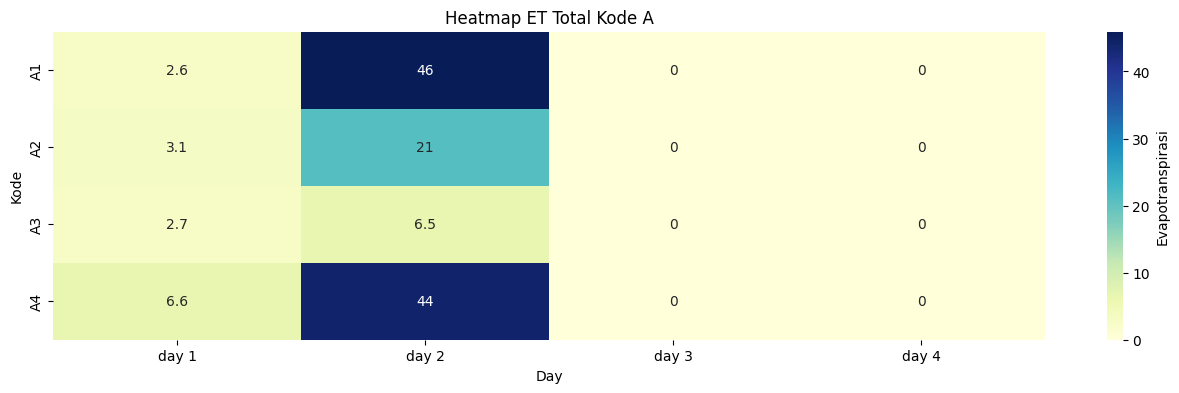

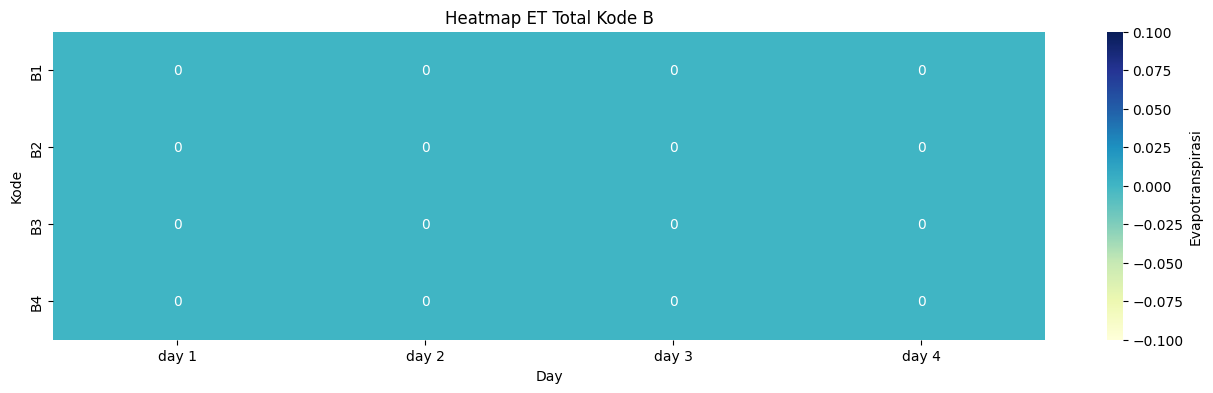

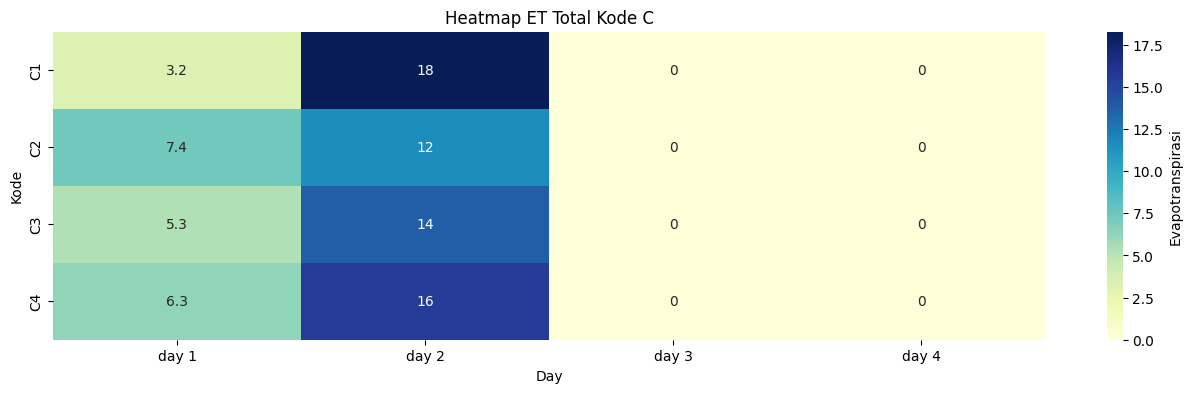

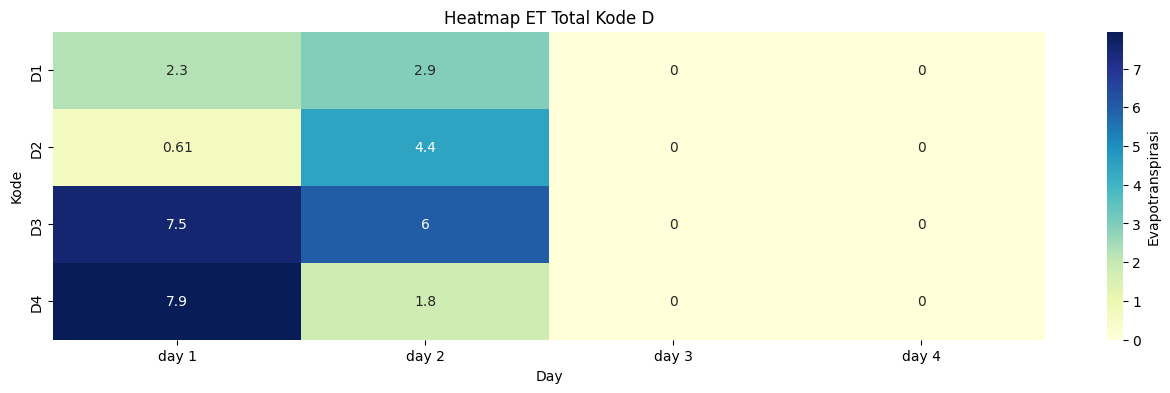

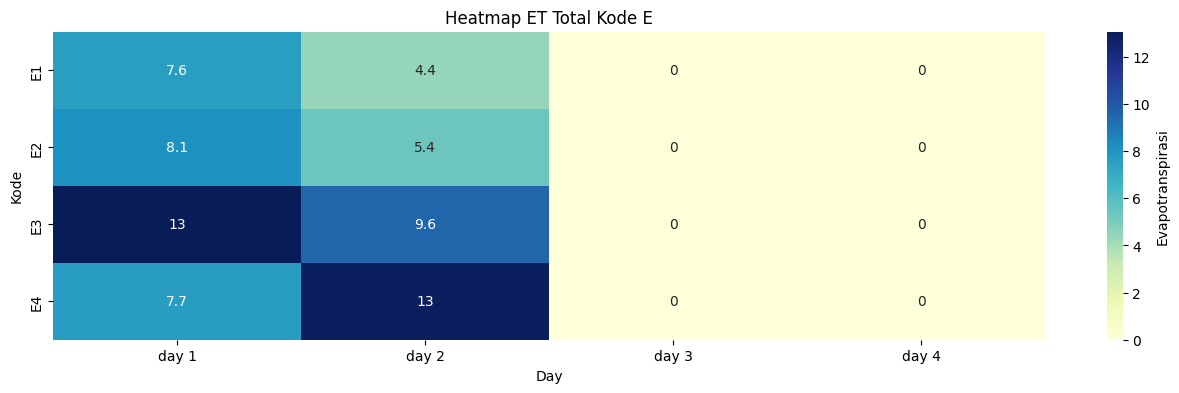

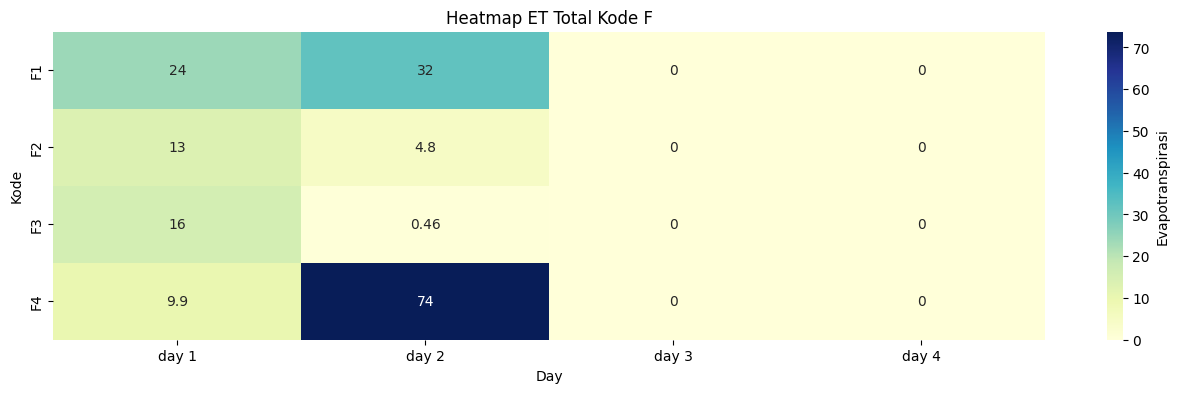

In [8]:
for group in kode_groups:
    # Filter kolom yang dimulai dengan grup kode yang sesuai
    df_group = df_hasil_gravimetri.filter(regex=f"^{group}")
    
    # Transpose DataFrame agar kode berada di sumbu y dan hari di sumbu x
    df_transposed = df_group.T

    # Plot heatmap untuk grup kode ini
    plt.figure(figsize=(16, 4))
    sns.heatmap(df_transposed, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Evapotranspirasi'})
    plt.title(f"Heatmap ET Total Kode {group}")
    plt.show()

# ET Model Blaney-Criddle

In [9]:
hasil_bc_model = []

for sheet_name in data_sekunder.sheet_names:
    # Baca data primer dan sekunder dari sheet excel
    df_data_sekunder = data_sekunder.parse(sheet_name)

    tanggal_data = hitung_tanggal_data(day = sheet_name)
    # print(f"{sheet_name} : {tanggal_data}")
    
    # Memasukkan nilai dataset ke dalam variabel
    suhu_udara = np.array(df_data_sekunder['suhu_udara'])
    # print(f"Suhu udara {sheet_name}: {suhu_udara}")

    # Menghitung rata-rata suhu udara
    mean_suhu_udara = np.mean(suhu_udara)
    # print(f"Rata-rata suhu udara: {mean_suhu_udara}")

    # Menghitung ET dengan model Blaney-Criddle
    et_model_bc = bc_model(persentase_hari_terang, mean_suhu_udara)
    # print(f"ET Blaney-Criddle: {et_model_bc}\n")

    # Simpan hasil ke list
    hasil_bc_model.append({
        "Day": sheet_name,
        "Tanggal": tanggal_data,
        "Mean Suhu Udara": mean_suhu_udara,
        "ET Total": et_model_bc
    })

# Buat DataFrame dari hasil
df_hasil_bc = pd.DataFrame(hasil_bc_model)

In [10]:
df_hasil_bc.head()

,Day,Tanggal,Mean Suhu Udara,ET Total
0,day 1,2024-10-22,30.01500,5.887863
1,day 2,2024-10-23,30.94875,6.003835
2,day 3,2024-10-24,31.14000,6.027588
3,day 4,2024-10-25,30.80625,5.986136
4,day 5,2024-10-26,30.90750,5.998712


# ET Model Hargreaves-Samani

In [11]:
hasil_hs_model = []

for sheet_name in data_sekunder.sheet_names:
    # Baca data primer dan sekunder dari sheet excel
    df_data_sekunder = data_sekunder.parse(sheet_name)
    
    # Memasukkan nilai dataset ke dalam variabel
    suhu_udara = np.array(df_data_sekunder['suhu_udara'])

    tanggal_data = hitung_tanggal_data(day = sheet_name)
    # print(f"{sheet_name} : {tanggal_data}")
    
    # Menghitung rata-rata, max, min, dan rentang suhu udara
    max_suhu_udara = np.max(suhu_udara)
    # print(f"Maksimal suhu udara: {max_suhu_udara}")
    min_suhu_udara = np.min(suhu_udara)
    # print(f"Minimal suhu udara: {min_suhu_udara}")
    rentang_suhu_udara = max_suhu_udara - min_suhu_udara
    # print(f"Rentang suhu udara: {rentang_suhu_udara}")
    mean_suhu_udara = (max_suhu_udara + min_suhu_udara) / 2
    # print(f"Rata-rata suhu udara: {mean_suhu_udara}")

    # Menghitung ET dengan model Hargreaves-Samani
    Ra, et_model_hs = hs_model(t_max = max_suhu_udara, t_min = min_suhu_udara, t_avg = mean_suhu_udara, 
                           latitude = latitude, input_date = tanggal_data)
    # print(f"ET Hargreaves-Samani: {et_model_hs}")
    # print(f"Radiasi atmosfer: {Ra}")

    # Simpan hasil ke list
    hasil_hs_model.append({
        "Day": sheet_name,
        "Tanggal": tanggal_data,
        "Max Suhu Udara": max_suhu_udara,
        "Min Suhu Udara": min_suhu_udara,
        "Mean Suhu Udara": mean_suhu_udara,
        "Rentang Suhu Udara": rentang_suhu_udara,
        "Radiasi Extrateresterial": Ra,
        "ET Total": et_model_hs
    })

# Buat DataFrame dari hasil
df_hasil_hs = pd.DataFrame(hasil_hs_model)

In [12]:
df_hasil_hs.head()

,Day,Tanggal,Max Suhu Udara,Min Suhu Udara,Mean Suhu Udara,Rentang Suhu Udara,Radiasi Extrateresterial,ET Total
0,day 1,2024-10-22,32.36,24.94,28.650,7.42,15.761121,1.576404
1,day 2,2024-10-23,33.47,25.65,29.560,7.82,15.769790,1.968924
2,day 3,2024-10-24,33.64,25.69,29.665,7.95,15.777863,2.098757
3,day 4,2024-10-25,33.05,25.68,29.365,7.37,15.785356,1.560391
4,day 5,2024-10-26,33.07,25.59,29.330,7.48,15.792283,1.654561


# ET Model Penman-Monteith

In [ ]:
hasil_pm_model = []

for sheet_name in data_sekunder.sheet_names:
    # Baca data primer dan sekunder dari sheet excel
    df_data_sekunder = data_sekunder.parse(sheet_name)
    
    tanggal_data = hitung_tanggal_data(day = sheet_name)
    # print(f"{sheet_name} : {tanggal_data}")

    # Memasukkan nilai dataset ke dalam variabel
    suhu_udara = np.array(df_data_sekunder['suhu_udara'])
    kecepatan_angin = np.array(df_data_sekunder['kecepatan_angin'])
    kelembapan_relatif = np.array(df_data_sekunder['kelembapan_relatif'])
    
    # Menghitung rata-rata kecepatan angin dan kelembapan relatif
    mean_kecepatan_angin = np.mean(kecepatan_angin)
    # print(f"Rata-rata kecepatan angin: {mean_kecepatan_angin}")
    mean_kelembapan_relatif = np.mean(kelembapan_relatif)
    # print(f"Rata-rata kelembapan relatif: {mean_kelembapan_relatif}")

    # Menghitung rata-rata, max, min, dan rentang suhu udara
    max_suhu_udara = np.max(suhu_udara)
    # print(f"Maksimal suhu udara: {max_suhu_udara}")
    min_suhu_udara = np.min(suhu_udara)
    # print(f"Minimal suhu udara: {min_suhu_udara}")
    mean_suhu_udara = (max_suhu_udara + min_suhu_udara) / 2
    # print(f"Rata-rata suhu udara: {mean_suhu_udara}")

    Ra = extraterrestrial_radiation(latitude, tanggal_data)
    
    
    # Menghitung ET dengan model Penman-monteith
    Ra, et_model_pm, total_et_model_pm = pm_model(RH = mean_kelembapan_relatif, u_2 = mean_kecepatan_angin, 
                                                 T_hr = suhu_udara, T_avg = mean_suhu_udara, 
                                                 T_max = max_suhu_udara, T_min = min_suhu_udara, 
                                                 altitude = altitude, latitude = latitude, 
                                                 input_date = tanggal_data)
    # print(f"ET Penman-monteith {sheet_name}: {total_et_model_pm}")
    # print(f"Radiasi atmosfer: {Ra}")

    # Simpan hasil ke list
    hasil_pm_model.append({
        "Day": sheet_name,
        "Tanggal": tanggal_data,
        "Max Suhu Udara": max_suhu_udara,
        "Min Suhu Udara": min_suhu_udara,
        "Mean Suhu Udara": mean_suhu_udara,
        "Mean Kecepatan Angin": mean_kecepatan_angin,
        "Mean Kelembapan Relatif": mean_kelembapan_relatif,
        "Radiasi Extrateresterial": Ra,
        "ET Total": total_et_model_pm
    })

# Buat DataFrame dari hasil
df_hasil_pm = pd.DataFrame(hasil_pm_model)

In [14]:
df_hasil_pm.head()

,Day,Tanggal,Max Suhu Udara,Min Suhu Udara,Mean Suhu Udara,Mean Kecepatan Angin,Mean Kelembapan Relatif,Radiasi Extrateresterial,ET Total
0,day 1,2024-10-22,32.36,24.94,28.650,3.06625,13.99125,15.761121,5.046710
1,day 2,2024-10-23,33.47,25.65,29.560,3.07750,13.77875,15.769790,5.303083
2,day 3,2024-10-24,33.64,25.69,29.665,2.41000,13.92250,15.777863,4.716969
3,day 4,2024-10-25,33.05,25.68,29.365,2.83750,14.90750,15.785356,5.001633
4,day 5,2024-10-26,33.07,25.59,29.330,3.80000,14.16625,15.792283,5.813109


# Plot Hasil

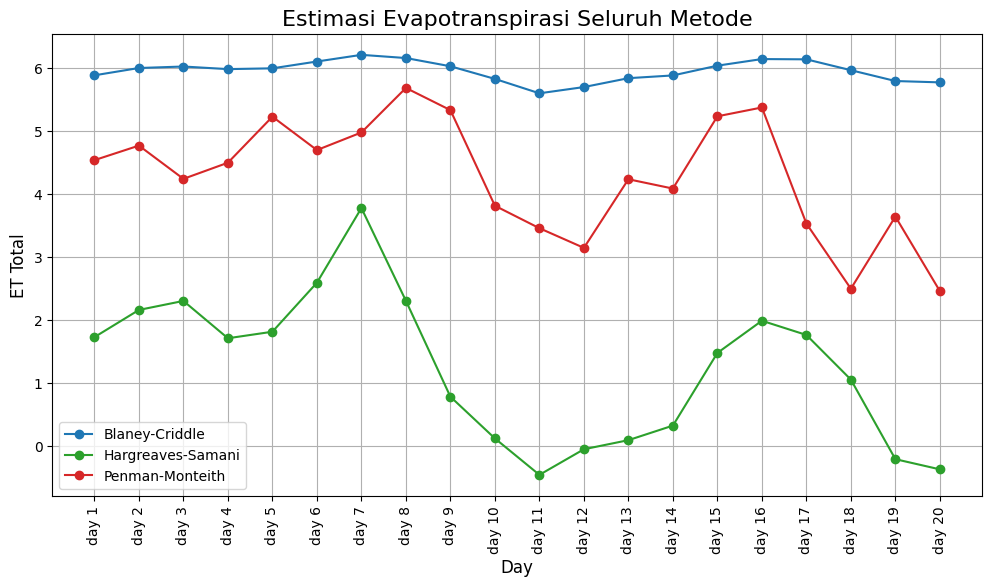

In [15]:
plt.figure(figsize=(12, 6))

# Data Blaney-Criddle
plt.plot(df_hasil_bc['Day'], df_hasil_bc['ET Total'], marker='o', linestyle='-', color='#1f77b4', label='Blaney-Criddle')

# Data Hargreaves-Samani
plt.plot(df_hasil_hs['Day'], df_hasil_hs['ET Total'] * 1.1, marker='o', linestyle='-', color='#2ca02c', label='Hargreaves-Samani')

# Data Penman-Monteith
plt.plot(df_hasil_pm['Day'], df_hasil_pm['ET Total'] * 0.9, marker='o', linestyle='-', color='#d62728', label='Penman-Monteith')

plt.title('Estimasi Evapotranspirasi Seluruh Metode', fontsize=16)
plt.xlabel('Day', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('ET Total', fontsize=12)

plt.grid(True)
plt.legend()
plt.show()